# Weigthed proximity analysis

Determine the amenities and servicies oppotunites with a weigthed value. The weigthed value is obtained dividing the amount of opportunities within 15min by the total amaount of opportunities for a given category.

__NOTE: Re-ran this notebook on 2025/08/21 in res 9 for streamlit. Named output table: f'volvo_wgtproxanalysis_2025_mza_hex{res}'__

## Import libraries

In [2]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

module_path = os.path.abspath(os.path.join('../../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup
else:
    import aup

## Notebook config

In [1]:
res = 9

## Download data

Proximity hexagons

In [10]:
hex_prox = aup.gdf_from_db(f'volvo_proxanalysis_2025_mza_hex{res}', 'projects_research')
print(hex_prox.shape)
hex_prox.head(2)

(6540, 44)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,time_guarderias,guarderias_15min,time_preescolar,preescolar_15min,...,time_escuelas,escuelas_15min,time_salud,salud_15min,time_equipamiento deportivo,equipamiento deportivo_15min,time_cultural,cultural_15min,time_financiero,financiero_15min
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,8.663587,2.517241,3.243826,8.931034,...,2.170799,19.362069,3.585968,7.724138,49.457691,0.000000,6.160919,4.931034,2.161552,44.120690
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,10.006852,1.000000,10.159873,2.628571,...,7.272814,7.485714,7.321409,2.657143,15.527184,0.685714,43.583564,0.000000,1.114521,12.342857


Amenities and services

In [4]:
# ---------------------------- BASE DATA REQUIRED ----------------------------
# Area of interest (city)
metro_schema = 'metropolis'
metro_table = 'metro_gdf_2020' #'metro_gdf_2015' or 'metro_gdf_2020'
# Network data (nodes and edges table for distance analysis,
# also used to generate the network G with which the nearest OSMID is assigned to each poi)
network_schema = 'osmnx'
nodes_table = 'nodes' #'nodes' or 'nodes_23_point'
edges_table = 'edges_speed' ################################################################################################## PENDIENTE
# Points of interest - DENUE
denue_schema = 'denue'
denue_table = 'denue_23_point' #'denue_2020' or 'denue_23_point'
# Points of interest - CLUES
clues_schema = 'denue'
clues_table = 'clues_23_point' #'clues' or 'clues_23_point'
# Points of interest - SIP
sip_schema = 'denue'
sip_table = 'sip_23_point' #'sip_2020' or 'sip_23_point'
# Points of interest - Espacio publico (Parques) ### Exclusive project Volvo
parques_schema = 'espacios_publicos' 
parques_table = 'ep_amg'
# Hexgrid
hex_schema = 'hexgrid'
# Population data
pop_schema = 'censo'
pop_table = 'hex_censo_mza_2020_res9' 

In [5]:
gdf = hex_prox.to_crs("EPSG:6372")
gdf = gdf.buffer(500).reset_index().rename(columns={0: "geometry"})
gdf = gdf.set_geometry("geometry")
gdf = gdf.to_crs("EPSG:4326")
poly_wkt = gdf.dissolve().geometry.to_wkt()[0]

In [6]:
parameters = {'Escuelas':{'Guarderias':{'denue_guarderias':[624411, 624412]},
                          'Preescolar':{'denue_preescolar':[611111, 611112]},
                          'Primaria':{'denue_primaria':[611121, 611122]},
                          'Secundaria':{'denue_secundaria':[611131, 611132]}
                         },
              'Salud':{'Primer_nivel':{'clues_primer_nivel':[8610]},
                       'Farmacias':{'denue_farmacias':[474111,464112]} ########## Volvo: 464111 Farmacias sin minisúper, 464112 Farmacias con minisúper
                       },
              'Parques':{'Parques':{'odc_parques':[9321]} ########## Volvo: AGREGAR DE BD, 
                                                          ########## Se le asignó el code 9321, correspondiente a 'Activities of amusement parks and theme parks'
                                                          ########## Fuente del code elegido: International Standard Industrial Classification of all Economic Activities, Rev.4
                                                          ########## https://unstats.un.org/unsd/publication/seriesm/seriesm_4rev4e.pdf
                        },
              'Equipamiento deportivo':{'Cancha':{'sip_cancha':[93110]},
                                        'Unidad_deportiva':{'sip_unidad_deportiva':[93111]}
                                       },
              'Cultural':{'Cines':{'denue_cines':[512130]},
                          'Museos':{'denue_museos':[712111, 712112]},
                          'Bibliotecas':{'denue_bibliotecas':[519121,519122]}
                         },
              'Financiero':{'Bancos':{'denue_bancos':[522110]} #################################################### Volvo: 522110 Banca Múltiple (Bancos y cajeros)
                           }
             }

In [7]:
####################################################################################################################################
# ADAPTATION
# Simplified version, does not filter centro cultural nor dif because it is not used in project Volvo.
####################################################################################################################################
def get_denue_pois(denue_schema,denue_table,poly_wkt,code):
    # This function downloads the codigo_act denue poi requested for the analysis.

    # Download denue pois
    query = f"SELECT * FROM {denue_schema}.{denue_table} WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = \'{code}\')"
    code_pois = aup.gdf_from_query(query, geometry_col='geometry')

    # Format denue pois
    code_pois = code_pois[['codigo_act', 'geometry']]
    code_pois = code_pois.rename(columns={'codigo_act':'code'})
    code_pois['code'] = code_pois['code'].astype('int64')

    return code_pois

In [8]:
####################################################################################################################################
# NEW
# Project Volvo includes 'parques', which are in OdC's DB
####################################################################################################################################
def get_parques_pois(parques_schema,parques_table,code):
    # This function creates parques points of interest out of vertices of parques found in db (schema>table)

    # Download parques pois
    query = f"SELECT * FROM {parques_schema}.{parques_table}"
    gdf = aup.gdf_from_query(query, geometry_col='geometry')
    gdf = gdf.to_crs("EPSG:4326")

    # Get vertices coordinates
    gdf_coords = gdf.geometry.get_coordinates()

    # Merge back with gdf containing data
    gdf_coords_data = pd.merge(gdf_coords,gdf,left_index=True,right_index=True)

    # Drop poly geometry 
    df_coords_data = gdf_coords_data.drop(columns=['geometry'])
    # Set points geometry
    gdf_2 = gpd.GeoDataFrame(df_coords_data, 
                             geometry=gpd.points_from_xy(df_coords_data.x, df_coords_data.y),
                             crs='EPSG:4326')
    # Format
    gdf_2.drop(columns=['x','y'],inplace=True)
    gdf_2.reset_index(inplace=True)
    gdf_2.rename(columns={'index':'polygon_id'},inplace=True)

    # Project Volvo filter
    # Tipos
    tipos = ['Parque','Espacio verde vecinal', 'Plaza', 'Área natural', 'Área natural protegida']
    gdf_f1 = gdf_2.loc[gdf_2.Tipo.isin(tipos)]
    # Usos
    gdf_f2 = gdf_f1.loc[gdf_f1.Uso == 'Uso recreativo']

    # Proxanalysis filter
    #code_pois = gdf_f2.set_crs("EPSG:4326")
    gdf_f2['code'] = code
    code_pois = gdf_f2[['polygon_id','code','geometry']]
    code_pois['code'] = code_pois['code'].astype('int64')

    code_pois = code_pois.drop_duplicates()

    return code_pois

Download CLUES and SIP

In [11]:
# 1.2 --------------- DOWNLOAD POINTS OF INTEREST (clues and sip pois, not denue)
# ------------------- This step downloads SIP and CLUES points of interest (denue pois are downloaded later.)

aoi = hex_prox[[f'hex_id_{res}','geometry']].copy()
city = 'Guadalajara'

sip_clues_gdf = gpd.GeoDataFrame()

# CLUES (Salud)
aup.log(f"--- Downloading CLUES pois for {city}.")
# Download
clues_gdf = aup.gdf_from_polygon(aoi, clues_schema, clues_table, geom_col="geometry")
# Filter
clues_pois = clues_gdf.loc[clues_gdf['nivel_atencion'] == 'PRIMER NIVEL'].copy()
del clues_gdf
# Format
clues_pois.loc[:,'code'] = 8610
clues_pois = clues_pois[['code','geometry']]
# Save to pois_tmp
sip_clues_gdf = pd.concat([sip_clues_gdf,clues_pois])
del clues_pois

# SIP (Marco geoestadistico)
# Download
sip_gdf = aup.gdf_from_polygon(aoi, sip_schema, sip_table, geom_col="geometry")
sip_amenities = {'GEOGRAFICO':['Mercado','Plaza'], 
                 'TIPO':['Cancha','Unidad Deportiva','Áreas Verdes','Jardín','Parque']}
# Filter - SIP pois of interest
sip_amenities_codes = {'Mercado':4721, #sip_mercado
                       'Cancha':93110, #sip_cancha
                       'Unidad Deportiva':93111, #sip_unidad_deportiva 
                       'Áreas Verdes':9321, #sip_espacio_publico 
                       'Jardín':9321, #sip_espacio_publico
                       'Parque':9321, #sip_espacio_publico
                       'Plaza':9321 #sip_espacio_publico
                        }
# Filter - Iterate over sip_amenities and filter sip gdf
sip_pois = gpd.GeoDataFrame()
for col in sip_amenities:
    for amenity in sip_amenities[col]:
        sip_tmp = sip_gdf.loc[sip_gdf[col] == amenity]
        sip_tmp.loc[:,'code'] = sip_amenities_codes[amenity]
        sip_pois = pd.concat([sip_pois,sip_tmp])
del sip_gdf
# Format
sip_pois = sip_pois[['code','geometry']]
# Save to pois_tmp
sip_clues_gdf = pd.concat([sip_clues_gdf,sip_pois])
del sip_pois

/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/opt/conda/envs/gds/lib/python3.9/site-packages/geopandas/geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [12]:
####################################################################################################################################
# ADAPTATION
# Added option for source being odc (In order skip it since for parks it will be slightly different).
# Removed 'version' from get_denue_pois
# Output renamed (nodes_analysis_1), will be concatenated with nodes_analysis_2 (Greenspace analysis)
####################################################################################################################################

# 1.3a --------------- ANALYSE POINTS OF INTEREST (If denue, downloads)
# ------------------- This step analysis times (and count of pois at given time proximity if requested) using function aup.pois_time.

poly_wkt = aoi.dissolve().geometry.to_wkt()[0]

i = 0
analysis_cols = []

count_pois = (True,15)

total_pois = {}

for eje in parameters.keys():
    for amenity in parameters[eje]:
        for source in parameters[eje][amenity]:
            if source[0] == 'o':
                print(f"---SKIPPING {source}.")
                continue
            
            print(f"""---Analysing source {source}.""")
            
            analysis_cols.append(source)
            if count_pois[0]:
                count_col = f'{source}_{count_pois[1]}min'
                analysis_cols.append(count_col)
            
            # ANALYSIS - Select source points of interest
            source_pois = gpd.GeoDataFrame()
            for code in parameters[eje][amenity][source]:
                #If source is denue:
                if source[0] == 'd':
                    print(f'--- Downloading denue source pois code {code} from db.')
                    code_pois = get_denue_pois(denue_schema,denue_table,poly_wkt,code)
                #If source is clues or sip:
                elif source[0] == 'c' or source[0] == 's':
                    print(f'--- Getting clues/sip source pois code {code} from previously downloaded.')
                    code_pois = sip_clues_gdf.loc[sip_clues_gdf['code'] == code]
                else:
                    print(f'--- Error, check parameters dicctionary.')
                    print(f'--- Sources must start with denue_, clues_, odc_ or sip_.')
                    intended_crash
                    
                source_pois = pd.concat([source_pois,code_pois])

            total_pois[count_col] = len(source_pois)

            print(f"--- {source_pois.shape[0]} {source} pois. Analysing source pois proximity to nodes.")
            

---Analysing source denue_guarderias.
--- Downloading denue source pois code 624411 from db.
--- Downloading denue source pois code 624412 from db.
--- 427 denue_guarderias pois. Analysing source pois proximity to nodes.
---Analysing source denue_preescolar.
--- Downloading denue source pois code 611111 from db.
--- Downloading denue source pois code 611112 from db.
--- 1669 denue_preescolar pois. Analysing source pois proximity to nodes.
---Analysing source denue_primaria.
--- Downloading denue source pois code 611121 from db.
--- Downloading denue source pois code 611122 from db.
--- 1482 denue_primaria pois. Analysing source pois proximity to nodes.
---Analysing source denue_secundaria.
--- Downloading denue source pois code 611131 from db.
--- Downloading denue source pois code 611132 from db.
--- 244 denue_secundaria pois. Analysing source pois proximity to nodes.
---Analysing source clues_primer_nivel.
--- Getting clues/sip source pois code 8610 from previously downloaded.
--- 70

In [13]:
total_pois

{'denue_guarderias_15min': 427,
 'denue_preescolar_15min': 1669,
 'denue_primaria_15min': 1482,
 'denue_secundaria_15min': 244,
 'clues_primer_nivel_15min': 700,
 'denue_farmacias_15min': 612,
 'sip_cancha_15min': 220,
 'sip_unidad_deportiva_15min': 67,
 'denue_cines_15min': 53,
 'denue_museos_15min': 47,
 'denue_bibliotecas_15min': 77,
 'denue_bancos_15min': 2924}

In [14]:
total_pois['odc_parques_15min'] = 2400

In [15]:
definitions = {}
for eje in parameters.keys():
    # tmp_dicc is {amenity:[source_list]} for each eje
    tmp_dicc = {}
    for amenity in parameters[eje]:
        items_lst = []
        items = list(parameters[eje][amenity].items())
        for item in items:
            items_lst.append(item[0])
        tmp_dicc[amenity] = items_lst
    # Each eje gets assigned its own tmp_dicc
    definitions[eje] = tmp_dicc

In [16]:
definitions

{'Escuelas': {'Guarderias': ['denue_guarderias'],
  'Preescolar': ['denue_preescolar'],
  'Primaria': ['denue_primaria'],
  'Secundaria': ['denue_secundaria']},
 'Salud': {'Primer_nivel': ['clues_primer_nivel'],
  'Farmacias': ['denue_farmacias']},
 'Parques': {'Parques': ['odc_parques']},
 'Equipamiento deportivo': {'Cancha': ['sip_cancha'],
  'Unidad_deportiva': ['sip_unidad_deportiva']},
 'Cultural': {'Cines': ['denue_cines'],
  'Museos': ['denue_museos'],
  'Bibliotecas': ['denue_bibliotecas']},
 'Financiero': {'Bancos': ['denue_bancos']}}

In [17]:
hex_wgt = hex_prox.copy()

In [18]:
column_count_all = []
# Go through each eje
for eje in definitions.keys():
    # Name of count eje
    eje_count_colname = f'{eje}_{count_pois[1]}min'.lower()
    # Append to lists
    column_count_all.append(eje_count_colname)
eje_count_colname

'financiero_15min'

In [19]:
definitions['Escuelas']['Guarderias']

['denue_guarderias']

In [20]:

# Go through each eje
for eje in definitions.keys():
    # Name of count eje
    eje_count_colname = f'{eje}_{count_pois[1]}min'.lower()
    # Append to lists
    column_count_all.append(eje_count_colname)

    # Go through eje's amenities
    column_count_amenities = []
    for amenity in definitions[eje]:
        # Name of count amenity
        amenity_count_colname = f'{amenity}_{count_pois[1]}min'.lower()
        # Append to lists
        column_count_all.append(amenity_count_colname)
        column_count_amenities.append(amenity_count_colname)

        # Gather amenities sources
        # column_count_sources = [] # Just used for sum function, not added at final output
        amenity_count = 0
        eje_count = 0
        for source in definitions[eje][amenity]:
            # Add to sources list
            amenity_count += total_pois[f'{source}_{count_pois[1]}min']
            eje_count += total_pois[f'{source}_{count_pois[1]}min']
        # Find sum of all sources found within given time of each node (For current amenity)
        hex_wgt['wgt_'+amenity_count_colname] = hex_wgt[amenity_count_colname] / amenity_count

    # Find sum of all sources found within given time of each node (For current eje)
    hex_wgt['wgt_'+eje_count_colname] = hex_wgt[eje_count_colname] / eje_count

print(hex_wgt.shape)
hex_wgt.head(2)

(6540, 62)


,hex_id_9,geometry,CVEGEO,NOMGEO,city,type,time_guarderias,guarderias_15min,time_preescolar,preescolar_15min,...,wgt_parques_15min,wgt_cancha_15min,wgt_unidad_deportiva_15min,wgt_equipamiento deportivo_15min,wgt_cines_15min,wgt_museos_15min,wgt_bibliotecas_15min,wgt_cultural_15min,wgt_bancos_15min,wgt_financiero_15min
0,89498c96e0bffff,"POLYGON ((-103.35267 20.66765, -103.35145 20.6...",14039,Guadalajara,Guadalajara,urban,8.663587,2.517241,3.243826,8.931034,...,0.004260,0.0,0.000000,0.000000,0.037736,0.039252,0.014107,0.064039,0.015089,0.015089
1,89498c960a3ffff,"POLYGON ((-103.34713 20.62771, -103.34591 20.6...",14039,Guadalajara,Guadalajara,urban,10.006852,1.000000,10.159873,2.628571,...,0.001619,0.0,0.010235,0.010235,0.000000,0.000000,0.000000,0.000000,0.004221,0.004221


In [21]:
hex_wgt.columns

Index(['hex_id_9', 'geometry', 'CVEGEO', 'NOMGEO', 'city', 'type',
       'time_guarderias', 'guarderias_15min', 'time_preescolar',
       'preescolar_15min', 'time_primaria', 'primaria_15min',
       'time_secundaria', 'secundaria_15min', 'time_primer_nivel',
       'primer_nivel_15min', 'time_farmacias', 'farmacias_15min',
       'time_cancha', 'cancha_15min', 'time_unidad_deportiva',
       'unidad_deportiva_15min', 'time_cines', 'cines_15min', 'time_museos',
       'museos_15min', 'time_bibliotecas', 'bibliotecas_15min', 'time_bancos',
       'bancos_15min', 'x', 'y', 'time_parques', 'parques_15min',
       'time_escuelas', 'escuelas_15min', 'time_salud', 'salud_15min',
       'time_equipamiento deportivo', 'equipamiento deportivo_15min',
       'time_cultural', 'cultural_15min', 'time_financiero',
       'financiero_15min', 'wgt_guarderias_15min', 'wgt_preescolar_15min',
       'wgt_primaria_15min', 'wgt_secundaria_15min', 'wgt_escuelas_15min',
       'wgt_primer_nivel_15min', 'wg

In [22]:
parameters = {'Escuelas':{'Guarderias':{'denue_guarderias':[624411, 624412]},
                          'Preescolar':{'denue_preescolar':[611111, 611112]},
                          'Primaria':{'denue_primaria':[611121, 611122]},
                          'Secundaria':{'denue_secundaria':[611131, 611132]}
                         },
              'Salud':{'Primer_nivel':{'clues_primer_nivel':[8610]},
                       'Farmacias':{'denue_farmacias':[474111,464112]} ########## Volvo: 464111 Farmacias sin minisúper, 464112 Farmacias con minisúper
                       },
              'Parques':{'Parques':{'odc_parques':[9321]} ########## Volvo: AGREGAR DE BD, 
                                                          ########## Se le asignó el code 9321, correspondiente a 'Activities of amusement parks and theme parks'
                                                          ########## Fuente del code elegido: International Standard Industrial Classification of all Economic Activities, Rev.4
                                                          ########## https://unstats.un.org/unsd/publication/seriesm/seriesm_4rev4e.pdf
                        },
              'Equipamiento deportivo':{'Cancha':{'sip_cancha':[93110]},
                                        'Unidad_deportiva':{'sip_unidad_deportiva':[93111]}
                                       },
              'Cultural':{'Cines':{'denue_cines':[512130]},
                          'Museos':{'denue_museos':[712111, 712112]},
                          'Bibliotecas':{'denue_bibliotecas':[519121,519122]}
                         },
              'Financiero':{'Bancos':{'denue_bancos':[522110]} #################################################### Volvo: 522110 Banca Múltiple (Bancos y cajeros)
                           }
             }

In [23]:
wgt_cat_list = ['wgt_escuelas_15min','wgt_salud_15min','wgt_parques_15min',
               'wgt_equipamiento deportivo_15min','wgt_cultural_15min',
               'wgt_financiero_15min']
hex_wgt['wgt_proximity_15min'] = hex_wgt[wgt_cat_list].sum(axis=1)

<Axes: >

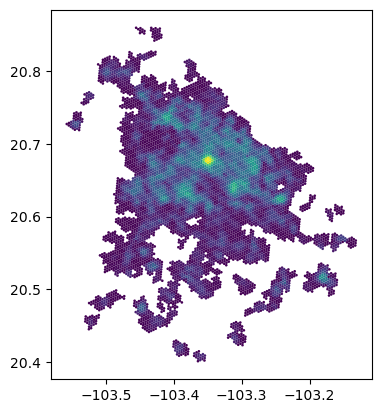

In [24]:
hex_wgt.plot('wgt_proximity_15min')

## Upload data

In [25]:
aup.gdf_to_db_slow(hex_wgt, f'volvo_wgtproxanalysis_2025_mza_hex{res}', 'projects_research', if_exists='replace')